In [3]:
import re
from collections import Counter

# C-like numeric array
import numpy as np

# dealing with table data
import pandas as pd

# a new data viz library
import altair as alt
alt.renderers.enable("notebook")

# from `SongShu.py`
from SongShu import SongShu

# SongShu -- Place Names Export (Part 2)

In the previous notebook, we used regex to capture the sentences with place names in the `劉宋地名與官名 2017-11-14.xlsx`. In this notebook, we would use this regex to export a list of place names. And we also list the frequencies the characters attached with these place names.

Tasks:
- **Part 1**: place names regex
- <span class="mark">**Part 2**: export place names (from `"劉宋地名與官名 2017-11-14.xlsx"`) and the frequency of characters attached on these place names</span>
- **Part 3**: export natural place names (using "洲", "山")

## Export Place Names

First, we repeat the processing we've done in the previous notebook.

In [6]:
# repeat the process

# loading Excel Sheet for place names
place_excel = pd.ExcelFile("劉宋地名與官名 2017-11-14.xlsx")
df_place    = pd.read_excel(place_excel, "Places") # reading the "Places" sheet

# replace the 郡
df_place.Name = [re.sub(r"(.+)?郡", r"\1", name) for name in df_place.Name]

# get an unique set of Names
place_name_set = set(df_place.Name)

# Get the SongShu Text
songshu = SongShu("2018-08-25", "MF")
songshu.load_htmls()

# preprocessing the songshu data to get metadata and bookmarks
# and separate the passages in every pages
songshu.extract_all()

# find the match place names in sentences
regex = r"([^、。，？！：；「」〔〕『』]*?)({})([^、。，？！：；「」〔〕『』]*)".format(r"|".join(place_name_set))
flat_place_names = []

# a horrible triple loop (lol)
# it takes some times ... since it is a horrible python for loop 😭
for passages in songshu.flat_passages:
    place_names = []
    for p in passages:
        place_names.append([
            (match.group(1), match.group(2), match.group(3)) 
            for match in re.finditer(regex, p)
        ])
        
    flat_place_names.append(place_names)

# preview the list
# the structure is like
# a sentence: (before the place name, place name, after the place name)        
flat_place_names[0][:2]

INFO:root:Stop at loading data/SongShu_0851.html.
INFO:root:Total length of the data is 851.
ERROR:root:[Error] SongShu_rare_char.json does not exist

            try to run these lines: 
            	>> self.extract_rare_chars()
            	>> self.write_rare_chars()



[[('', '彭城', '縣綏輿里人'),
  ('辟彊生', '陽城', '繆侯德'),
  ('德生', '陽城', '節侯安民'),
  ('安民生', '陽城', '釐侯慶忌'),
  ('慶忌生', '陽城', '肅侯岑'),
  ('平生', '東武', '城令某'),
  ('某生', '東萊', '太守景'),
  ('洽生', '博', '士弘'),
  ('悝生', '魏', '定襄太守某'),
  ('膺生', '相', '國掾熙'),
  ('居', '晉陵', '郡丹徒縣之京口里'),
  ('官至', '武原', '令'),
  ('混生', '東安', '太守靖'),
  ('高祖以晉哀帝', '興寧', '元年歲次癸亥三月壬寅夜生')],
 [('初為', '冠軍', '孫無終司馬'),
  ('妖賊孫恩作亂於', '會稽', ''),
  ('牢之至', '吳', ''),
  ('', '平山', '陰')]]

Writing to a `csv` file. I would keep 2 blank columns for longitude and latitude.

For convenience, I just keep the first of `all_possible_IDs` for `ID`. 

In [7]:
# using indexing! My co-workers would hate me 😅
# tuple for the csv file
csv = [ (
    df_place.ID[df_place.Name == sentence[1]].tolist()[0],   # first ID
    sentence[1],           # place name
    None, None,            # lon, lat
    ''.join([s for s in sentence if isinstance(s, str)]),    # The sentence include the tag
    set(df_place.ID[df_place.Name == sentence[1]].tolist()), # all possible IDs, since a place name referring to multiple IDs
    meta['category'],      # category
    meta['scroll'],        # scroll
    meta['title'],         # title
    ) 
    for place_names,meta in zip(flat_place_names, songshu.flat_meta) 
    for place_name in place_names
    for sentence in place_name
] 
# this list comprehension is kind of slooow...

csv[0]

('lsp0102',
 '彭城',
 None,
 None,
 '彭城縣綏輿里人',
 {'lsp0102', 'lsp0139', 'lsp3030'},
 '本紀',
 '卷一',
 '武帝\u3000劉裕\u3000上(P.1)')

Making a DataFrame

In [8]:
df_export_csv = pd.DataFrame(
    csv, 
    columns=['ID', 'Place_Name', 'lon', 'lat', 
             'sentence', 'all_possible_IDs', 
             'category', 'scroll', 'title']
)
df_export_csv.head()

,ID,Place_Name,lon,lat,sentence,all_possible_IDs,category,scroll,title
0,lsp0102,彭城,None,None,彭城縣綏輿里人,"{lsp0102, lsp0139, lsp3030}",本紀,卷一,武帝 劉裕 上(P.1)
1,lsp0191,陽城,None,None,辟彊生陽城繆侯德,{lsp0191},本紀,卷一,武帝 劉裕 上(P.1)
2,lsp0191,陽城,None,None,德生陽城節侯安民,{lsp0191},本紀,卷一,武帝 劉裕 上(P.1)
3,lsp0191,陽城,None,None,安民生陽城釐侯慶忌,{lsp0191},本紀,卷一,武帝 劉裕 上(P.1)
4,lsp0191,陽城,None,None,慶忌生陽城肅侯岑,{lsp0191},本紀,卷一,武帝 劉裕 上(P.1)


## Finding lon lat in the File

In [9]:
!ls

1_Head_西都賦(P.5).csv
1_Passage_西都賦(P.5).csv
1_Passage_西都賦(P.5).xml
Bayesian Chinese Character Matching.ipynb
Bayesian TimePeriod Matching.ipynb
BenJi.html
Book -- Basic Usage.ipynb
Book -- XML readable conversion.ipynb
Book.py
Book.py -- Cleaner Design.ipynb
Chinese_Family_Name（1k）.xlsx
Classical Chinese Tutorial -- Counter as an Efficient Way to Do N-Gram.ipynb
GeoAPITest.csv
Han-Ji -- Scrapping Data.ipynb
Han-Ji Class Design.ipynb
HanJi_csv2xml.py
LDA -- n-grams feature extraction in sklearn.ipynb
MARKUS-added-text.html
MARKUS.html
Naive Bayes -- Class for Naive Bayes.ipynb
Naive Bayes -- Class to Calculate Single Phrase Posterior Probability .ipynb
Naive Bayes Place Name Classification.ipynb
Naive Bayes Time Phrase Classification.ipynb
Naive.py
PreQin.py
README.md
Scraping.py
Shishuo xinyu_0000.html
Shishuo.html
ShishuoTextCommScript.py
Skip Certain Kind of Tags in BS4 Object.ipynb
SongShu -- Export Natural Geo-Names (洲、山 as an example).ipynb
SongShu -- File 0546 Extraction Geographi

In [ ]:
df_lon_lat = pd.read_excel("")

In [5]:
# saving dataframe
df_export_csv.to_csv("SongShu_placeTags_lonlat.csv")

## Frequency of Characters Attached with Place Names

- 1 char before place name
- 1 char after place name
- 2 char before place name
- 2 char after place name

In [7]:
df_sentence_tuples = pd.DataFrame(
    [tup for place_names in flat_place_names for place_name in place_names for tup in place_name],
    columns=['before_tag', 'tag', 'after_tag']
)

df_sentence_tuples.head()

,before_tag,tag,after_tag
0,None,彭城,縣綏輿里人
1,辟彊生,陽城,繆侯德
2,德生,陽城,節侯安民
3,安民生,陽城,釐侯慶忌
4,慶忌生,陽城,肅侯岑


### Top 20 freq char before place names.

[('為', 1292), ('屬', 649), ('南', 575), ('王', 433), ('於', 369), ('史', 365), ('帝', 316), ('之', 316), ('至', 297), ('以', 289), ('封', 281), ('軍', 251), ('見', 245), ('郡', 226), ('有', 207), ('州', 194), ('鎮', 192), ('在', 192), ('東', 186), ('平', 165)]


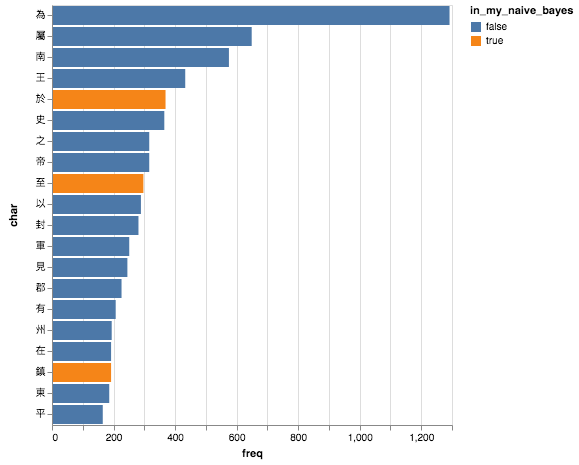

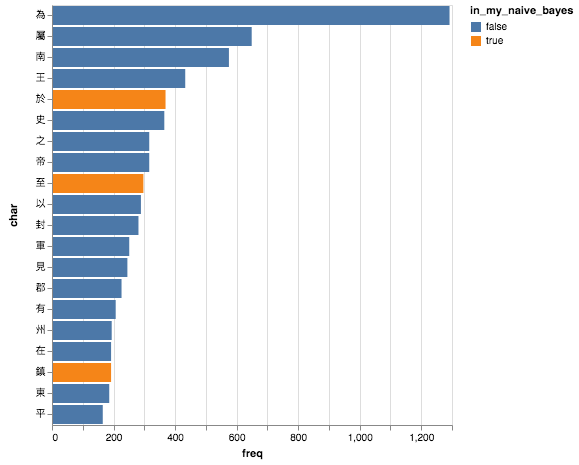

In [8]:
# freq of one char before
# remember to remove None
counter = Counter( 
    [tag[-1] for tag in df_sentence_tuples.before_tag if tag != None] 
).most_common(20)

print(counter)

# Altair plotting
data = pd.DataFrame(
    {'char' : [char for char, freq in counter],
    'freq' : [freq for char, freq in counter],
    'in_my_naive_bayes' : [char in "至于於向破奔鎮入征" for char, freq in counter]
    }
)
alt.Chart(data).mark_bar().encode(
    x='freq',
    y=alt.Y('char', sort=alt.SortField(field="freq", op="sum", order="descending")), 
    color='in_my_naive_bayes'
)

### Top 20 freq chars after place names.

[('王', 1323), ('刺', 1143), ('令', 1106), ('太', 831), ('縣', 674), ('郡', 634), ('之', 581), ('軍', 487), ('將', 432), ('州', 345), ('二', 286), ('人', 284), ('門', 270), ('國', 253), ('恭', 235), ('立', 209), ('熙', 205), ('康', 196), ('宣', 193), ('平', 192)]


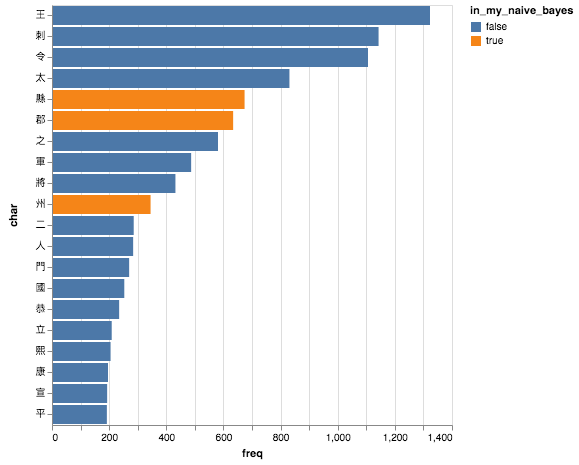

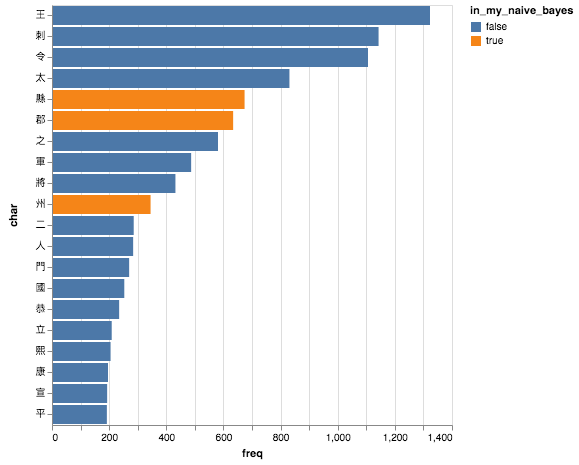

In [9]:
# freq of one char before
# remember to remove None
counter = Counter( 
    [tag[0] for tag in df_sentence_tuples.after_tag if tag != None] 
).most_common(20)

print(counter)

# Altair plotting
data = pd.DataFrame(
    {'char' : [char for char, freq in counter],
    'freq' : [freq for char, freq in counter],
    'in_my_naive_bayes' : [char in "鄉市縣鎮郡城州" for char, freq in counter]
    }
)
alt.Chart(data).mark_bar().encode(
    x='freq',
    y=alt.Y('char', sort=alt.SortField(field="freq", op="sum", order="descending")), 
    color='in_my_naive_bayes'
)

What??? What happens to `"二"`?

In [10]:
# preview some sample
[''.join([btag,tag,atag]) for btag,tag,atag in zip(df_sentence_tuples.before_tag, 
                           df_sentence_tuples.tag, 
                           df_sentence_tuples.after_tag) 
     if (atag != None and btag != None and tag != None)
     if atag[0] == '二'][::10] 

['南秦二州刺史',
 '南秦二州刺史',
 '南秦二州刺史',
 '南秦二州刺史',
 '帝錫二祖',
 '漢桓帝永興二年四月',
 '吳孫亮建興二年',
 '晉元帝永昌二年七月丙子朔',
 '東京兆二僑郡',
 '晉哀帝興寧二年',
 '巴西梓潼二郡太守',
 '襄陽新野二郡太守',
 '梁南秦二州刺史',
 '南彭城下邳二郡太守',
 '兗徐二州刺史',
 '南琅邪泰山二郡太守',
 '前汝南潁川二郡太守龐天生',
 '南沛二郡太守劉懷之率人民一時渡江']

OK, it makes sense. "二" means 二郡 （同時兩個郡） or 二州 or some mistakes tagging on time names.

### Top 20 two chars before place names

In [11]:
# loading 官名
df_bureaucracy = pd.read_excel(place_excel, "Offices")

[('刺史', 325), ('將軍', 160), ('漢屬', 138), ('夏王', 128), ('志屬', 116), ('為南', 86), ('出為', 84), ('太守', 76), ('以為', 70), ('城王', 64), ('之為', 61), ('安帝', 56), ('理生', 56), ('譙王', 44), ('二州', 44), ('川王', 43), ('文帝', 42), ('吳興', 41), ('琅邪', 40), ('改封', 40)]


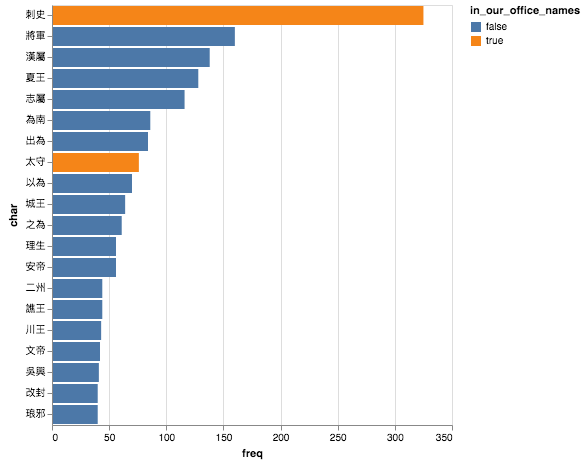

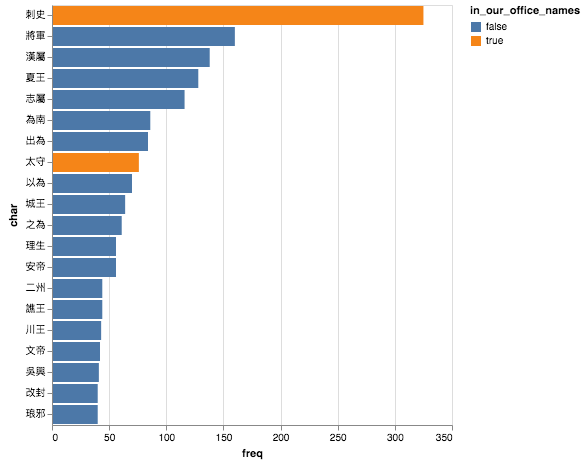

In [12]:
# freq of one char before
# remember to remove None
counter = Counter( 
    [tag[-2:] for tag in df_sentence_tuples.before_tag if tag != None if len(tag[-2:]) == 2] 
).most_common(20)

print(counter)

# Altair plotting
data = pd.DataFrame(
    {'char' : [char for char, freq in counter],
    'freq' : [freq for char, freq in counter],
     'in_our_office_names' : [char in df_bureaucracy.Name.values for char,freq in counter]
    }
)
alt.Chart(data).mark_bar().encode(
    x='freq',
    y=alt.Y('char', sort=alt.SortField(field="freq", op="sum", order="descending")), 
    color='in_our_office_names'
)

I am curious about `"夏王"`:

In [13]:
[''.join([btag,tag,atag]) for btag,tag,atag in zip(df_sentence_tuples.before_tag, 
                           df_sentence_tuples.tag, 
                           df_sentence_tuples.after_tag) 
     if (atag != None and btag != None and tag != None)
     if btag[-2:] == '夏王'][::10]

['荊州刺史江夏王義恭為征北將軍',
 '太宰江夏王義恭加中書監',
 '錄尚書江夏王義恭等十二人立議同',
 '嘉禾二株生江夏王義恭東田',
 '幸太宰江夏王義恭第',
 '又除江夏王義恭驃騎中兵參軍',
 '江夏王義恭太尉行參軍',
 '常與江夏王義恭寢食不離於側',
 '江夏王義恭為征北將軍',
 '又為江夏王義恭太尉參軍',
 '又別詔太宰江夏王義恭曰',
 '江夏王義恭',
 '江夏王義恭以太保領大宗師']

So, all of these are wrong. Apparently, single char place name, like "義", has high probability to be wrong. Note: [劉義恭](https://zh.wikipedia.org/wiki/%E5%8A%89%E7%BE%A9%E6%81%AD)

### Top 20 two chars after place names

[('刺史', 1142), ('太守', 791), ('將軍', 342), ('軍事', 340), ('州刺', 192), ('王子', 162), ('王休', 155), ('文帝', 126), ('郡太', 116), ('人也', 116), ('元年', 107), ('縣侯', 105), ('門侍', 104), ('二郡', 92), ('內史', 86), ('王誕', 68), ('王濬', 64), ('明帝', 63), ('二年', 62), ('興太', 58)]


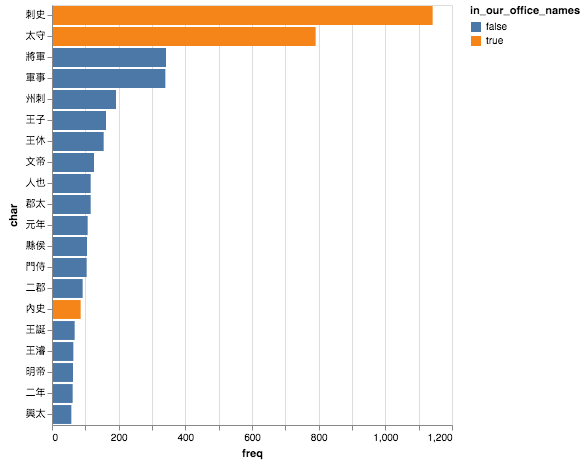

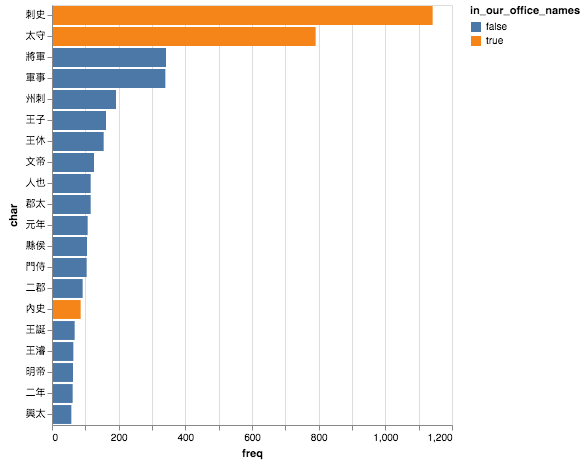

In [14]:
# freq of one char before
# remember to remove None
counter = Counter( 
    [tag[:2] for tag in df_sentence_tuples.after_tag if tag != None if len(tag[:2]) == 2] 
).most_common(20)

print(counter)

# Altair plotting
data = pd.DataFrame(
    {'char' : [char for char, freq in counter],
    'freq' : [freq for char, freq in counter],
    'in_our_office_names' : [char in df_bureaucracy.Name.values for char,freq in counter]
    }
)
alt.Chart(data).mark_bar().encode(
    x='freq',
    y=alt.Y('char', sort=alt.SortField(field="freq", op="sum", order="descending")), 
    color='in_our_office_names'
)

It seems some time chars are wrongly assigned as place names.

I would STOP🛑 here. There are further more Altair interactive plots to be explored. We can try to deal with embedding Altair plots in the `.html` next time.

### (Supplementary) Encoding freq of a chars after and before tags as X-Y axis

In [15]:
# counting freq of 1 char before and after the place names
counter_before = Counter( 
    [tag[-1:] for tag in df_sentence_tuples.before_tag if tag != None] 
)

counter_after  = Counter( 
    [tag[:1] for tag in df_sentence_tuples.after_tag if tag != None] 
)

# making {char : (freq before tag, freq after tag)} form
before_after_pairs = {}

for char,freq in counter_before.items():
    try:
        before_after_pairs[char] = (freq, counter_after[char])
    except IndexError as e:
        before_after_pairs[char] = (freq, 0)
        
for char,freq in counter_after.items():
    if char not in before_after_pairs.keys():
        before_after_pairs[char] = (0, freq)

len(before_after_pairs)

2425

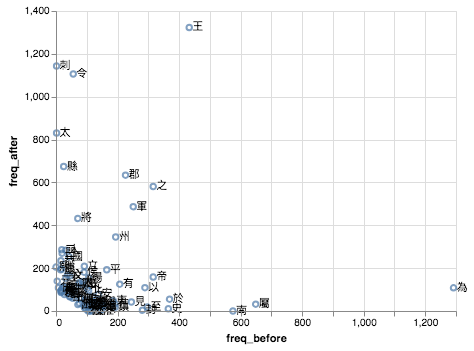

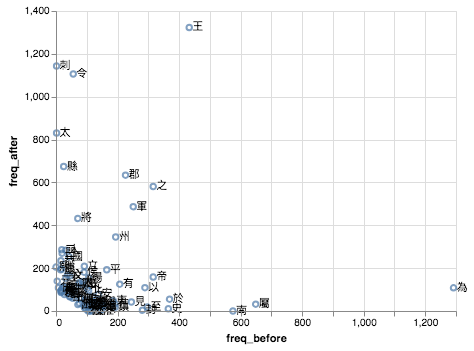

In [16]:
# cut-off the small numbers (sum of the pair of the freqs is small)
data = pd.DataFrame({ char : pair
    for char, pair in before_after_pairs.items()
    if sum(pair) > 100
    }, index=['freq_before', 'freq_after']).T

chart = alt.Chart(data.reset_index()).mark_point().encode(
    x='freq_before',
    y='freq_after',
)

text = chart.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='index'
)

chart + text

Make it cleaner

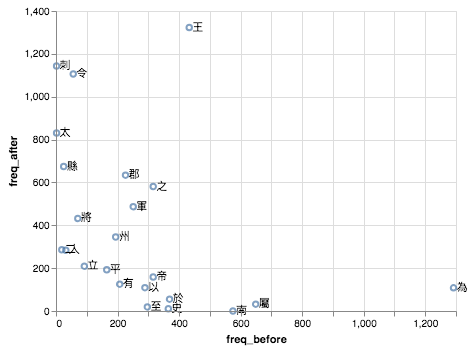

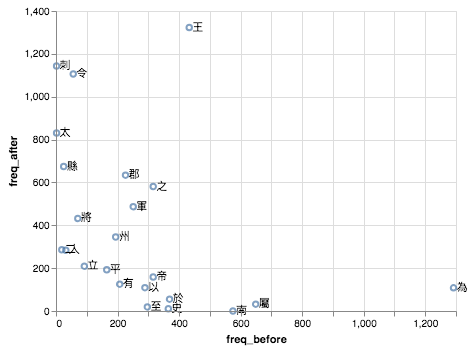

In [17]:
# cut-off the small numbers (sum of the pair of the freqs is small)
data = pd.DataFrame({ char : pair
    for char, pair in before_after_pairs.items()
    if sum(pair) > 300
    }, index=['freq_before', 'freq_after']).T

chart = alt.Chart(data.reset_index()).mark_point().encode(
    x='freq_before',
    y='freq_after',
)

text = chart.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='index'
)

chart + text